### By Nicholas Vachon (5152902), Orlando Marquez (1062617), Raul Chavez (1182956)

In [1]:
%pylab inline

import numpy as np
from pprint import pprint
from numpy import linalg as LA
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
# fonction plot
def gridplot(classifieur,train,test,title,n_points=50):

    train_test = np.vstack((train,test))
    (min_x1,max_x1) = (min(train_test[:,0])-0.5, max(train_test[:,0])+0.5)
    (min_x2,max_x2) = (min(train_test[:,1])-0.1, max(train_test[:,1])+0.1)

    xgrid = np.linspace(min_x1,max_x1,num=n_points)
    ygrid = np.linspace(min_x2,max_x2,num=n_points)

	# calcule le produit cartesien entre deux listes
    # et met les resultats dans un array
    thegrid = np.array(combine(xgrid,ygrid))

    les_comptes = classifieur.compute_predictions(thegrid)
    classesPred = les_comptes    

    plt.figure(1, figsize=(10, 10))
    
    # La grille
    # Pour que la grille soit plus jolie
    #props = dict( alpha=0.3, edgecolors='none' )
    #pylab.scatter(thegrid[:,0],thegrid[:,1],c = classesPred, s=50, edgecolors='none')
    plt.pcolormesh(xgrid, ygrid, classesPred.reshape((n_points, n_points)).T, alpha=.3)
	# Les points d'entrainment
    plt.scatter(train[:,0], train[:,1], c = train[:,-1], marker = 'v', s=150)
    # Les points de test
    plt.scatter(test[:,0], test[:,1], c = test[:,-1], marker = 's', s=150)

    ## Un petit hack, parce que la fonctionalite manque a pylab...
    h1, = plt.plot([min_x1], [min_x2], marker='o', c = 'w',ms=5) 
    h2, = plt.plot([min_x1], [min_x2], marker='v', c = 'w',ms=5) 
    h3, = plt.plot([min_x1], [min_x2], marker='s', c = 'w',ms=5) 
    handles = [h1,h2,h3]
    ## fin du hack

    labels = ['grille','train','test']
    plt.legend(handles,labels)
    plt.title(title)

    #pylab.axis('equal')
    plt.show()
    
## http://code.activestate.com/recipes/302478/
def combine(*seqin):
    '''returns a list of all combinations of argument sequences.
for example: combine((1,2),(3,4)) returns
[[1, 3], [1, 4], [2, 3], [2, 4]]'''
    def rloop(seqin,listout,comb):
        '''recursive looping function'''
        if seqin:                       # any more sequences to process?
            for item in seqin[0]:
                newcomb=comb+[item]     # add next item to current comb
                # call rloop w/ rem seqs, newcomb
                rloop(seqin[1:],listout,newcomb)
        else:                           # processing last sequence
            listout.append(comb)        # comb finished, add to list
    listout=[]                      # listout initialization
    rloop(seqin,listout,[])         # start recursive process
    return listout

In [3]:
def softmax(x):
   # x est matrice mxn
   maxparcol = np.max(x, axis = 0)                  #vecteur 1xn
   num = np.exp(x - maxparcol)                      #matrice mxn
   deno = np.sum(np.exp(x - maxparcol), axis = 0)   #vecteur 1xn
   return num / deno                                #matrice mxn

def softmax_v(v):
    max_v = np.max(v)
    return np.exp(v - max_v)/np.sum(np.exp(v-max_v))

#Input: m x k matrix where m is the number of classes and k is the number of samples.
#The softmax will be applied over columns
def softmax_m(M):
    to_return = np.zeros(M.T.shape)
    
    for (i, col) in enumerate(M.T):
        to_return[i] = softmax_v(col)
        
    return to_return.T

def softmax_mb(M):
    return np.exp(M - np.max(M, axis=1).dot(np.ones(M.shape)))/np.array([np.sum(np.exp(M - np.max(M, axis=1).dot(np.ones(M.shape))), axis=1)]).T

# t = np.array([4, 5, 6])
# M = np.array([[1, 2, 3],[10, 5, 7]])
# print softmax_m(M)
# print softmax_mb(M)

# print "--"
# a = np.array([[-3.77155825],[ 3.77155825]])
# print softmax_v(a)
# print softmax(a)

### Questions 1 and 2

In [4]:
class mlp_single_example_test:
    
    def __init__(self, eta, d, dh, m, epsilon, l11, l12, l21, l22):
        self.l11 = l11
        self.l12 = l12
        self.l21 = l21
        self.l22 = l22
        self.epsilon = epsilon
        self.eta = eta
        self.d = d
        self.dh = dh
        self.m = m
        self.w1 = np.random.uniform(-1.0/np.sqrt(self.d), 1.0/np.sqrt(self.d), (self.dh, self.d))
        self.w2 = np.random.uniform(-1.0/np.sqrt(self.dh), 1.0/np.sqrt(self.dh), (self.m, self.dh))
        self.b1 = np.zeros((dh, 1))
        self.b2 = np.zeros((m, 1))
    
    #Only for a single data point
    def fprop(self, x):
        self.ha = self.w1.dot(x.T) + self.b1
        self.hs = np.where(self.ha > 0, self.ha, 0)
        self.oa = self.w2.dot(self.hs) + self.b2
        self.os = softmax_v(self.oa) #TODO use softmax_mb for matrices
        
    def bprop(self, x, y):
        self.grad_oa = self.os - np.array([np.eye(self.m)[y]]).T 
        self.grad_b2 = self.grad_oa
        
        self.grad_w2 = self.grad_oa.dot(self.hs.T)
        #Handle the regularizer
        self.grad_w2 = np.add(self.grad_w2, 2*self.l22*self.w2)
        self.grad_w2 = np.add(self.grad_w2, self.l21*np.sign(self.w2))
        
        self.grad_hs = self.w2.T.dot(self.grad_oa)
        self.grad_ha = np.where(self.ha > 0, self.grad_hs, 0)
        self.grad_w1 = self.grad_ha.dot(x)
        #Handle the regularizer
        self.grad_w1 = np.add(self.grad_w1, 2*self.l12*self.w1)
        self.grad_w1 = np.add(self.grad_w1, self.l11*np.sign(self.w1))
        
        self.grad_b1 = self.grad_ha
    
    def apply_gradient_descent(self):    
        self.w1-= self.eta*self.grad_w1
        self.w2-= self.eta*self.grad_w2
        self.b1-= self.eta*self.grad_b1
        self.b2-= self.eta*self.grad_b2
                
    #Regularized cost
    def cost(self, y):
        return -np.log(self.os[y][0]) + self.l12*(np.sum(self.w1**2)) + \
            self.l11*np.sum(np.abs(self.w1)) + self.l21*np.sum(np.abs(self.w2)) + self.l22*(np.sum(self.w2**2))
    
    def print_vars(self):
        pprint(vars(self))
 
#Test gradients for a single example
x = np.array([[1, 2]])
y = 0

mlp = mlp_single_example_test(0.01, 2, 2, 2, epsilon=0.0001, l11=0.1, l12=0.1, l21=0.1, l22=0.1)
mlp.fprop(x)
mlp.bprop(x, y)        
cost1 = mlp.cost(y)

####For w1#######
for i in range(2):
    for j in range(2):
        mlp.w1[i][j]+= mlp.epsilon
        mlp.fprop(x)
        cost2 = mlp.cost(y)
        estimate_gradient = (cost2 - cost1)/mlp.epsilon
        print "Test w1[{}][{}]".format(i, j)
        print "Bprop gradient:", mlp.grad_w1[i][j]
        print "Finite difference estimate", estimate_gradient
        if (mlp.grad_w1[i][j] == 0 and estimate_gradient == 0):
            print "Ratio:", 1
        else:
            print "Ratio:", mlp.grad_w1[i][j]/estimate_gradient

        mlp.w1[i][j]-= mlp.epsilon

print "-------------------------"        
####For w2#######
for i in range(2):
    for j in range(2):
        mlp.w2[i][j]+= mlp.epsilon
        mlp.fprop(x)
        cost2 = mlp.cost(y)
        estimate_gradient = (cost2 - cost1)/mlp.epsilon
        print "Test w2[{}][{}]".format(i, j)
        print "Bprop gradient:", mlp.grad_w2[i][j]
        print "Finite difference estimate", estimate_gradient
        if (mlp.grad_w2[i][j] == 0 and estimate_gradient == 0):
            print "Ratio:", 1
        else:
            print "Ratio:", mlp.grad_w2[i][j]/estimate_gradient

        mlp.w2[i][j]-= mlp.epsilon

print "-------------------------"        
####For b1#######
for i in range(2):
    mlp.b1[i]+= mlp.epsilon
    mlp.fprop(x)
    cost2 = mlp.cost(y)
    estimate_gradient = (cost2 - cost1)/mlp.epsilon
    print "Test b1[{}]".format(i)
    print "Bprop gradient:", mlp.grad_b1[i]
    print "Finite difference estimate", estimate_gradient
    if (mlp.grad_b1[i] == 0 and estimate_gradient == 0):
        print "Ratio:", 1
    else:
        print "Ratio:", mlp.grad_b1[i]/estimate_gradient

    mlp.b1[i]-= mlp.epsilon      

print "-------------------------"        
####For b2#######
for i in range(2):
    mlp.b2[i]+= mlp.epsilon
    mlp.fprop(x)
    cost2 = mlp.cost(y)
    estimate_gradient = (cost2 - cost1)/mlp.epsilon
    print "Test b2[{}]".format(i)
    print "Bprop gradient:", mlp.grad_b2[i]
    print "Finite difference estimate", estimate_gradient
    if (mlp.grad_b2[i] == 0 and estimate_gradient == 0):
        print "Ratio:", 1
    else:
        print "Ratio:", mlp.grad_b2[i]/estimate_gradient

    mlp.b2[i]-= mlp.epsilon   
        

Test w1[0][0]
Bprop gradient: 0.0996951671198
Finite difference estimate 0.0997056242169
Ratio: 0.999895120289
Test w1[0][1]
Bprop gradient: 0.0230826646986
Finite difference estimate 0.0230944930846
Ratio: 0.999487826559
Test w1[1][0]
Bprop gradient: -0.105582230319
Finite difference estimate -0.105572230318
Ratio: 1.00009472189
Test w1[1][1]
Bprop gradient: -0.193031106172
Finite difference estimate -0.193021106172
Ratio: 1.00005180781
-------------------------
Test w2[0][0]
Bprop gradient: -0.442377993788
Finite difference estimate -0.442346188768
Ratio: 1.00007190074
Test w2[0][1]
Bprop gradient: -0.2119278481
Finite difference estimate -0.211917848101
Ratio: 1.00004718809
Test w2[1][0]
Bprop gradient: 0.480701659829
Finite difference estimate 0.480733465096
Ratio: 0.999933840122
Test w2[1][1]
Bprop gradient: 0.222429309698
Finite difference estimate 0.222439309697
Ratio: 0.999955043921
-------------------------
Test b1[0]
Bprop gradient: [-0.0840943]
Finite difference estimate -0.

### Questions 3 and 4

In [5]:
class mlp_mini_batch_test:
    
    def __init__(self, eta, d, dh, m, epsilon, minibatch_size, l11, l12, l21, l22):
        self.l11 = l11
        self.l12 = l12
        self.l21 = l21
        self.l22 = l22
        self.epsilon = epsilon
        self.K = minibatch_size
        self.eta = eta
        self.d = d
        self.dh = dh
        self.m = m
        self.w1 = np.random.uniform(-1.0/np.sqrt(self.d), 1.0/np.sqrt(self.d), (self.dh, self.d))
        self.w2 = np.random.uniform(-1.0/np.sqrt(self.dh), 1.0/np.sqrt(self.dh), (self.m, self.dh))
        
        self.b1 = np.zeros((dh, 1))
        self.b2 = np.zeros((m, 1))
        
        self.mb_grad_w1 = np.zeros((self.dh, self.d))
        self.mb_grad_w2 = np.zeros((self.m, self.dh))
        self.mb_grad_b1 = np.zeros((dh, 1))
        self.mb_grad_b2 = np.zeros((m, 1))
        
    def train(self, traindata):
        
        #Do 1 mini-batch
        samples = traindata[:self.K, :-1]
        labels = traindata[:self.K, -1]
        self.mb_costs = 0.0
        
        for (x, y) in zip (samples, labels):
            x = np.array([x]) # since we are doing one example at a time, create a matrix so we can transpose x
            self.fprop(x)
            self.bprop(x, y)      
            self.mb_costs += self.cost(y)
                        
        self.mb_grad_w2 = self.mb_grad_w2/self.K
        self.mb_grad_b2 = self.mb_grad_b2/self.K
        self.mb_grad_w1 = self.mb_grad_w1/self.K
        self.mb_grad_b1 = self.mb_grad_b1/self.K
        
        #Handle the regularizer - once per batch
        self.mb_grad_w2 = np.add(self.mb_grad_w2, 2*self.l22*self.w2)
        self.mb_grad_w2 = np.add(self.mb_grad_w2, self.l21*np.sign(self.w2))
        
        #Handle the regularizer - once per batch
        self.mb_grad_w1 = np.add(self.mb_grad_w1, 2*self.l12*self.w1)
        self.mb_grad_w1 = np.add(self.mb_grad_w1, self.l11*np.sign(self.w1))        
        
        #Add the regularization to the cost
        self.mb_costs = self.mb_costs/self.K + self.l12*(np.sum(self.w1**2)) + \
            self.l11*np.sum(np.abs(self.w1)) + self.l21*np.sum(np.abs(self.w2)) + self.l22*(np.sum(self.w2**2))
    
    #Only for a single data point
    def fprop(self, x):      
        self.ha = self.w1.dot(x.T) + self.b1
        self.hs = np.where(self.ha > 0, self.ha, 0)
        self.oa = self.w2.dot(self.hs) + self.b2
        self.os = softmax_v(self.oa)
        
    def bprop(self, x, y):
        self.grad_oa = self.os - np.array([np.eye(self.m)[np.int(y)]]).T 
        self.grad_b2 = self.grad_oa
        self.grad_w2 = self.grad_oa.dot(self.hs.T)
        
        self.grad_hs = self.w2.T.dot(self.grad_oa)
        self.grad_ha = np.where(self.ha > 0, self.grad_hs, 0)
        self.grad_w1 = self.grad_ha.dot(x)
        
        self.grad_b1 = self.grad_ha
        
        #Accumulate minibatch gradients
        self.mb_grad_w2 = np.add(self.mb_grad_w2, self.grad_w2)
        self.mb_grad_b2 = np.add(self.mb_grad_b2, self.grad_b2)
        self.mb_grad_w1 = np.add(self.mb_grad_w1, self.grad_w1)
        self.mb_grad_b1 = np.add(self.mb_grad_b1, self.grad_b1)
            
    def apply_gradient_descent(self):    
        self.w1-= self.eta*self.grad_w1
        self.w2-= self.eta*self.grad_w2
        self.b1-= self.eta*self.grad_b1
        self.b2-= self.eta*self.grad_b2
                
    def cost(self, y):
        return -np.log(self.os[np.int(y)][0])     
    
    def print_vars(self):
        pprint(vars(self))
        
#Test gradients for a mini-batch
mlp = mlp_mini_batch_test(0.01, 2, 2, 2, epsilon=0.0001, minibatch_size=2, l11=0.1, l12=0.1, l21=0.1, l22=0.1)
traindata = np.loadtxt(open('2moons.txt','r'))
mlp.train(traindata)

samples = traindata[:mlp.K, :-1]
labels = traindata[:mlp.K, -1]

####For w1#######
for i in range(2):
    for j in range(2):
        estimate_costs = 0.0
        mlp.w1[i][j]+= mlp.epsilon
        
        for (x, y) in zip (samples, labels):
            x = np.array([x])
            mlp.fprop(x)    
            estimate_costs += mlp.cost(y)

        estimate_costs = estimate_costs/mlp.K + mlp.l12*(np.sum(mlp.w1**2)) + \
            mlp.l11*np.sum(np.abs(mlp.w1)) + mlp.l21*np.sum(np.abs(mlp.w2)) + mlp.l22*(np.sum(mlp.w2**2)) 
        estimate_gradient = (estimate_costs - mlp.mb_costs)/mlp.epsilon
        print "Test w1[{}][{}]".format(i, j)
        print "Bprop gradient:", mlp.mb_grad_w1[i][j]
        print "Finite difference estimate:", estimate_gradient
        print "Ratio:", mlp.mb_grad_w1[i][j]/estimate_gradient
        mlp.w1[i][j]-= mlp.epsilon

print "-------------------------"        
####For w2#######
for i in range(2):
    for j in range(2):
        estimate_costs = 0.0
        mlp.w2[i][j]+= mlp.epsilon
        
        for (x, y) in zip (samples, labels):
            x = np.array([x])
            mlp.fprop(x)    
            estimate_costs += mlp.cost(y)

        estimate_costs = estimate_costs/mlp.K + mlp.l12*(np.sum(mlp.w1**2)) + \
            mlp.l11*np.sum(np.abs(mlp.w1)) + mlp.l21*np.sum(np.abs(mlp.w2)) + mlp.l22*(np.sum(mlp.w2**2)) 
        estimate_gradient = (estimate_costs - mlp.mb_costs)/mlp.epsilon
        print "Test w2[{}][{}]".format(i, j)
        print "Bprop gradient:", mlp.mb_grad_w2[i][j]
        print "Finite difference estimate:", estimate_gradient
        print "Ratio:", mlp.mb_grad_w2[i][j]/estimate_gradient
        mlp.w2[i][j]-= mlp.epsilon
        
print "-------------------------"        
####For b1#######
for i in range(2):
    estimate_costs = 0.0
    mlp.b1[i]+= mlp.epsilon

    for (x, y) in zip (samples, labels):
        x = np.array([x])
        mlp.fprop(x)    
        estimate_costs += mlp.cost(y)

    estimate_costs = estimate_costs/mlp.K + mlp.l12*(np.sum(mlp.w1**2)) + \
            mlp.l11*np.sum(np.abs(mlp.w1)) + mlp.l21*np.sum(np.abs(mlp.w2)) + mlp.l22*(np.sum(mlp.w2**2))  
    estimate_gradient = (estimate_costs - mlp.mb_costs)/mlp.epsilon
    print "Test b1[{}]".format(i)
    print "Bprop gradient:", mlp.mb_grad_b1[i]
    print "Finite difference estimate:", estimate_gradient
    print "Ratio:", mlp.mb_grad_b1[i]/estimate_gradient
    mlp.b1[i]-= mlp.epsilon
    
print "-------------------------"        
####For b2#######
for i in range(2):
    estimate_costs = 0.0
    mlp.b2[i]+= mlp.epsilon

    for (x, y) in zip (samples, labels):
        x = np.array([x])
        mlp.fprop(x)    
        estimate_costs += mlp.cost(y)

    estimate_costs = estimate_costs/mlp.K + mlp.l12*(np.sum(mlp.w1**2)) + \
            mlp.l11*np.sum(np.abs(mlp.w1)) + mlp.l21*np.sum(np.abs(mlp.w2)) + mlp.l22*(np.sum(mlp.w2**2)) 
    estimate_gradient = (estimate_costs - mlp.mb_costs)/mlp.epsilon
    print "Test b2[{}]".format(i)
    print "Bprop gradient:", mlp.mb_grad_b2[i]
    print "Finite difference estimate:", estimate_gradient
    print "Ratio:", mlp.mb_grad_b2[i]/estimate_gradient
    mlp.b2[i]-= mlp.epsilon

Test w1[0][0]
Bprop gradient: 0.191729261169
Finite difference estimate: 0.191753034779
Ratio: 0.999876019639
Test w1[0][1]
Bprop gradient: -0.894534792681
Finite difference estimate: -0.894494027548
Ratio: 1.0000455734
Test w1[1][0]
Bprop gradient: 0.222203522102
Finite difference estimate: 0.222213607914
Ratio: 0.999954612084
Test w1[1][1]
Bprop gradient: -0.321643643097
Finite difference estimate: -0.321631570648
Ratio: 1.00003753502
-------------------------
Test w2[0][0]
Bprop gradient: -0.199222663071
Finite difference estimate: -0.199210886378
Ratio: 1.00005911672
Test w2[0][1]
Bprop gradient: -0.366761962822
Finite difference estimate: -0.366750131409
Ratio: 1.00003226015
Test w2[1][0]
Bprop gradient: 0.183748790652
Finite difference estimate: 0.183760567327
Ratio: 0.999935912937
Test w2[1][1]
Bprop gradient: 0.0325795867573
Finite difference estimate: 0.0325914181576
Ratio: 0.999636978045
-------------------------
Test b1[0]
Bprop gradient: [ 0.160565]
Finite difference estima

### Question 5

In [6]:
class mlp_mini_batch:
    
    def __init__(self, eta, d, dh, m, epsilon, minibatch_size, num_iterations, l11, l12, l21, l22, hardcode_weights=False):
        self.l11 = l11
        self.l12 = l12
        self.l21 = l21
        self.l22 = l22
        self.epsilon = epsilon
        self.K = minibatch_size
        self.num_iterations = num_iterations
        self.eta = eta
        self.d = d
        self.dh = dh
        self.m = m
        self.w1 = np.random.uniform(-1.0/np.sqrt(self.d), 1.0/np.sqrt(self.d), (self.dh, self.d))
        self.w2 = np.random.uniform(-1.0/np.sqrt(self.dh), 1.0/np.sqrt(self.dh), (self.m, self.dh))        
        self.b1 = np.zeros((dh, 1))
        self.b2 = np.zeros((m, 1))
        
        if (hardcode_weights == True):
            self.w1[0][0] = -0.5
            self.w1[0][1] = 0.5
            self.w1[1][0] = -0.3
            self.w1[1][1] = 0.3

            self.w2[0][0] = -0.4
            self.w2[0][1] = 0.4
            self.w2[1][0] = -0.6
            self.w2[1][1] = 0.2
        
        self.mb_grad_w1 = np.zeros((self.dh, self.d))
        self.mb_grad_w2 = np.zeros((self.m, self.dh))
        self.mb_grad_b1 = np.zeros((dh, 1))
        self.mb_grad_b2 = np.zeros((m, 1))
        
    def train(self, traindata):                        
        
        iteration = 0        
        
        while iteration < self.num_iterations:
            
            self.loss = 0            
            start_batch_i = 0
            end_batch_i = np.minimum(self.K, traindata.shape[0])
        
            while start_batch_i < traindata.shape[0]: 

                samples = traindata[start_batch_i:end_batch_i, :-1]
                labels = traindata[start_batch_i:end_batch_i, -1]
                
                self.mb_grad_w1 = np.zeros((self.dh, self.d))
                self.mb_grad_w2 = np.zeros((self.m, self.dh))
                self.mb_grad_b1 = np.zeros((self.dh, 1))
                self.mb_grad_b2 = np.zeros((self.m, 1))
                self.mb_cost = 0

                for (x, y) in zip (samples, labels):
                    # since we are doing one example at a time, create a matrix so we can transpose x
                    x = np.array([x]) 
                    self.fprop(x)
                    self.bprop(x, y)      
                    self.mb_cost += self.cost(y)
                    
                self.mb_grad_w2 = self.mb_grad_w2/samples.shape[0]
                self.mb_grad_b2 = self.mb_grad_b2/samples.shape[0]
                self.mb_grad_w1 = self.mb_grad_w1/samples.shape[0]
                self.mb_grad_b1 = self.mb_grad_b1/samples.shape[0] 
                
                #Handle the regularizer - once per batch
                self.mb_grad_w2 = np.add(self.mb_grad_w2, 2*self.l22*self.w2)
                self.mb_grad_w2 = np.add(self.mb_grad_w2, self.l21*np.sign(self.w2))

                #Handle the regularizer - once per batch
                self.mb_grad_w1 = np.add(self.mb_grad_w1, 2*self.l12*self.w1)
                self.mb_grad_w1 = np.add(self.mb_grad_w1, self.l11*np.sign(self.w1))   
                
                #Add the regularization to the cost
                self.loss += self.mb_cost/samples.shape[0] + self.l12*(np.sum(self.w1**2)) + \
                    self.l11*np.sum(np.abs(self.w1)) + self.l21*np.sum(np.abs(self.w2)) + self.l22*(np.sum(self.w2**2))                

                self.apply_gradient_descent()

                start_batch_i = end_batch_i
                end_batch_i = np.minimum(end_batch_i + self.K, traindata.shape[0])

            #print "Total loss after iter {}:{}".format(iteration, self.loss/traindata.shape[0])
            
            iteration+=1                 
    
    #Only for a single data point
    def fprop(self, x):
        self.ha = self.w1.dot(x.T) + self.b1                        
        self.hs = np.where(self.ha > 0, self.ha, 0)
        self.oa = self.w2.dot(self.hs) + self.b2
        self.os = softmax_v(self.oa)
        
        return self.os
        
    def bprop(self, x, y):
        self.grad_oa = self.os - np.array([np.eye(self.m)[np.int(y)]]).T 
        self.grad_b2 = self.grad_oa
        self.grad_w2 = self.grad_oa.dot(self.hs.T)
        
        self.grad_hs = self.w2.T.dot(self.grad_oa)
        self.grad_ha = np.where(self.ha > 0, self.grad_hs, 0)
        self.grad_w1 = self.grad_ha.dot(x)     
        
        self.grad_b1 = self.grad_ha
        
        #Accumulate minibatch gradients
        self.mb_grad_w2 = np.add(self.mb_grad_w2, self.grad_w2)
        self.mb_grad_b2 = np.add(self.mb_grad_b2, self.grad_b2)
        self.mb_grad_w1 = np.add(self.mb_grad_w1, self.grad_w1)
        self.mb_grad_b1 = np.add(self.mb_grad_b1, self.grad_b1)
            
    def apply_gradient_descent(self):    
        self.w1-= self.eta*self.mb_grad_w1
        self.w2-= self.eta*self.mb_grad_w2
        self.b1-= self.eta*self.mb_grad_b1
        self.b2-= self.eta*self.mb_grad_b2
                
    def cost(self, y):
        return -np.log(self.os[np.int(y)][0])   
    
    def print_vars(self):
        pprint(vars(self))
        
    #Parameter test_data does not contain labels
    #Return list of predictions
    def compute_predictions(self, test_data):
        #argmax over axis=0 because fprop will return matrix of shape (# of classes, # of data points)
        return np.argmax(self.fprop(test_data), axis=0)

### Explore the effect of number of hidden neurons

training error: 23.8636363636
test error: 25.9090909091


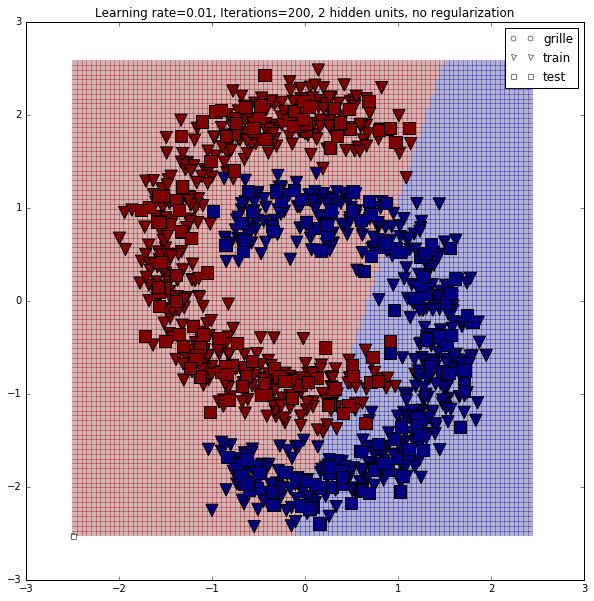

In [68]:
data = np.loadtxt(open('2moons.txt','r'))

n_train = np.int(data.shape[0]*0.8)
inds = range(data.shape[0])
np.random.shuffle(inds)
train_inds = inds[:n_train]
test_inds = inds[n_train:]

traindata = data[train_inds,:]  
testdata = data[test_inds,:]

mlp = mlp_mini_batch(0.1, 2, 2, 2, epsilon=0.0001, minibatch_size=1, num_iterations=200, \
                     l11=0, l12=0, l21=0, l22=0)

mlp.train(traindata)

train_predictions = mlp.compute_predictions(traindata[:, :-1])
train_labels = traindata[:,-1]
train_err = 1.0 - np.mean(train_labels==train_predictions)
print "training error:",train_err*100

test_predictions = mlp.compute_predictions(testdata[:, :-1])
test_labels = testdata[:,-1]
test_err = 1.0 - np.mean(test_labels==test_predictions)
print "test error:",test_err*100

gridplot(classifieur=mlp, test=testdata, train=traindata, n_points=100, \
         title='Learning rate=0.1, Iterations=200, 2 hidden units, no regularization')


training error: 1.93181818182
test error: 3.18181818182


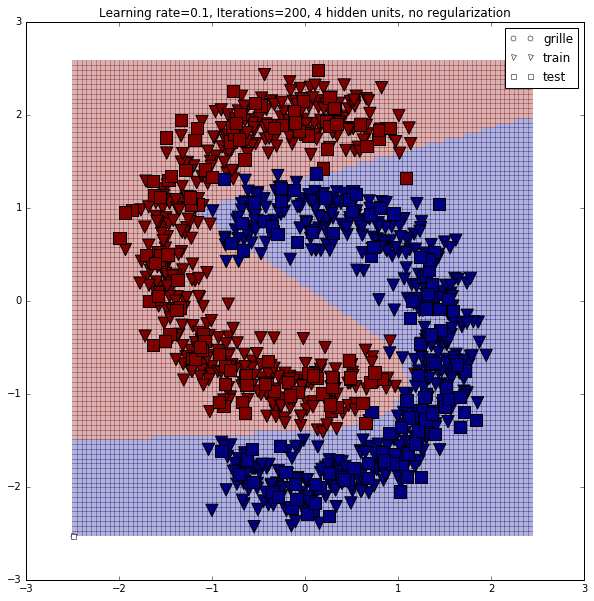

In [70]:
n_train = np.int(data.shape[0]*0.8)
inds = range(data.shape[0])
np.random.shuffle(inds)
train_inds = inds[:n_train]
test_inds = inds[n_train:]

traindata = data[train_inds,:]  
testdata = data[test_inds,:]

mlp = mlp_mini_batch(0.1, 2, 4, 2, epsilon=0.0001, minibatch_size=10, num_iterations=200, \
                     l11=0, l12=0, l21=0, l22=0)

mlp.train(traindata)

train_predictions = mlp.compute_predictions(traindata[:, :-1])
train_labels = traindata[:,-1]
train_err = 1.0 - np.mean(train_labels==train_predictions)
print "training error:",train_err*100

test_predictions = mlp.compute_predictions(testdata[:, :-1])
test_labels = testdata[:,-1]
test_err = 1.0 - np.mean(test_labels==test_predictions)
print "test error:",test_err*100

gridplot(classifieur=mlp, test=testdata, train=traindata, n_points=100, \
         title='Learning rate=0.1, Iterations=200, 4 hidden units, no regularization')

training error: 1.47727272727
test error: 0.909090909091


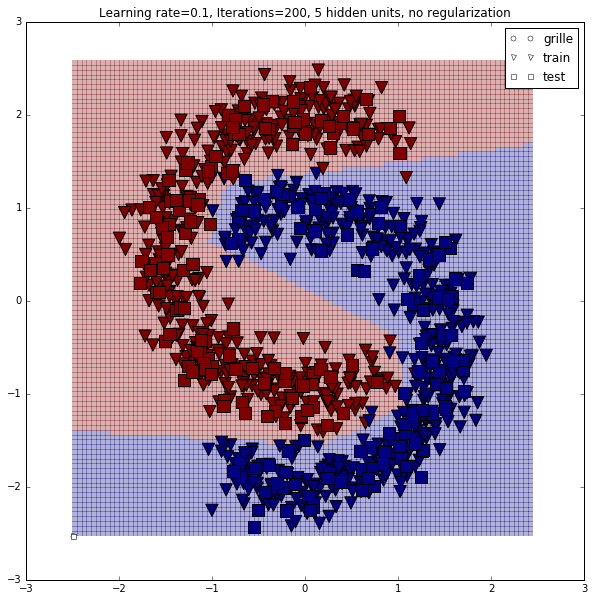

In [73]:
n_train = np.int(data.shape[0]*0.8)
inds = range(data.shape[0])
np.random.shuffle(inds)
train_inds = inds[:n_train]
test_inds = inds[n_train:]

traindata = data[train_inds,:]  
testdata = data[test_inds,:]

mlp = mlp_mini_batch(0.1, 2, 5, 2, epsilon=0.0001, minibatch_size=10, num_iterations=200, \
                     l11=0, l12=0, l21=0, l22=0)

mlp.train(traindata)

train_predictions = mlp.compute_predictions(traindata[:, :-1])
train_labels = traindata[:,-1]
train_err = 1.0 - np.mean(train_labels==train_predictions)
print "training error:",train_err*100

test_predictions = mlp.compute_predictions(testdata[:, :-1])
test_labels = testdata[:,-1]
test_err = 1.0 - np.mean(test_labels==test_predictions)
print "test error:",test_err*100

gridplot(classifieur=mlp, test=testdata, train=traindata, n_points=100, \
         title='Learning rate=0.1, Iterations=200, 5 hidden units, no regularization')


training error: 0.795454545455
test error: 0.909090909091


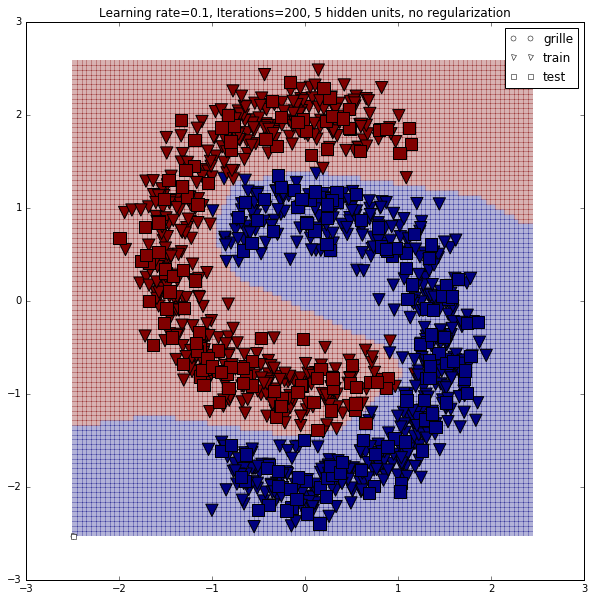

In [113]:
n_train = np.int(data.shape[0]*0.8)
inds = range(data.shape[0])
np.random.shuffle(inds)
train_inds = inds[:n_train]
test_inds = inds[n_train:]

traindata = data[train_inds,:]  
testdata = data[test_inds,:]

mlp = mlp_mini_batch(0.1, 2, 10, 2, epsilon=0.0001, minibatch_size=10, num_iterations=200, \
                     l11=0, l12=0, l21=0, l22=0)

mlp.train(traindata)

train_predictions = mlp.compute_predictions(traindata[:, :-1])
train_labels = traindata[:,-1]
train_err = 1.0 - np.mean(train_labels==train_predictions)
print "training error:",train_err*100

test_predictions = mlp.compute_predictions(testdata[:, :-1])
test_labels = testdata[:,-1]
test_err = 1.0 - np.mean(test_labels==test_predictions)
print "test error:",test_err*100

gridplot(classifieur=mlp, test=testdata, train=traindata, n_points=100, \
         title='Learning rate=0.1, Iterations=200, 5 hidden units, no regularization')

#### The three examples above demonstrate that for this particular data set, having more neurons in the hidden layer helps us have enough capacity to obtain a lower error rate in the test data. It seems that at least 5 neurons are needed to have good error rates. However, running many times with 5 neurons and shuffling the data, sometimes we get higher error rates. So to have more stable results, choose at least 10 hidden neurons

### Explore the effect of number of epochs (early stopping)

training error: 9.31818181818
test error: 10.9090909091


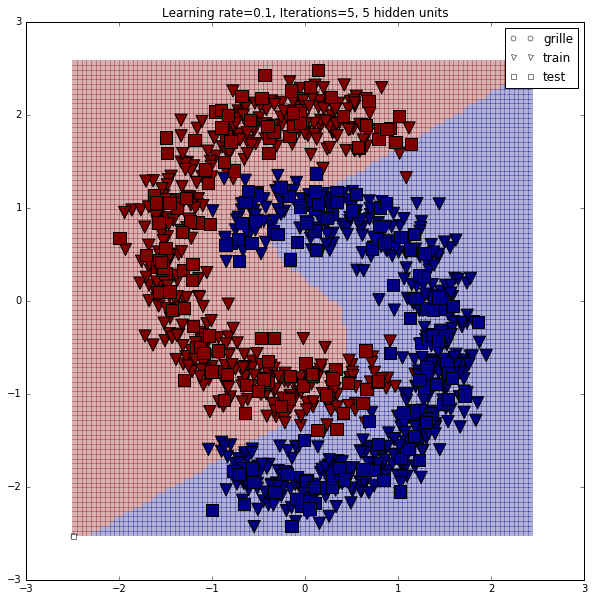

In [114]:
n_train = np.int(data.shape[0]*0.8)
inds = range(data.shape[0])
np.random.shuffle(inds)
train_inds = inds[:n_train]
test_inds = inds[n_train:]

traindata = data[train_inds,:]  
testdata = data[test_inds,:]

mlp = mlp_mini_batch(0.1, 2, 10, 2, epsilon=0.0001, minibatch_size=10, num_iterations=5, \
                     l11=0, l12=0, l21=0, l22=0)

mlp.train(traindata)

train_predictions = mlp.compute_predictions(traindata[:, :-1])
train_labels = traindata[:,-1]
train_err = 1.0 - np.mean(train_labels==train_predictions)
print "training error:",train_err*100

test_predictions = mlp.compute_predictions(testdata[:, :-1])
test_labels = testdata[:,-1]
test_err = 1.0 - np.mean(test_labels==test_predictions)
print "test error:",test_err*100

gridplot(classifieur=mlp, test=testdata, train=traindata, n_points=100, \
         title='Learning rate=0.1, Iterations=5, 5 hidden units')


training error: 3.40909090909
test error: 5.90909090909


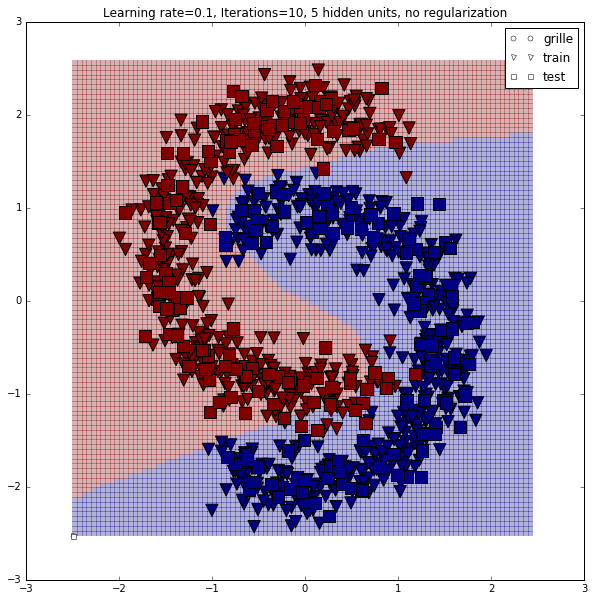

In [117]:
n_train = np.int(data.shape[0]*0.8)
inds = range(data.shape[0])
np.random.shuffle(inds)
train_inds = inds[:n_train]
test_inds = inds[n_train:]

traindata = data[train_inds,:]  
testdata = data[test_inds,:]

mlp = mlp_mini_batch(0.1, 2, 10, 2, epsilon=0.0001, minibatch_size=10, num_iterations=10, \
                     l11=0, l12=0, l21=0, l22=0)

mlp.train(traindata)

train_predictions = mlp.compute_predictions(traindata[:, :-1])
train_labels = traindata[:,-1]
train_err = 1.0 - np.mean(train_labels==train_predictions)
print "training error:",train_err*100

test_predictions = mlp.compute_predictions(testdata[:, :-1])
test_labels = testdata[:,-1]
test_err = 1.0 - np.mean(test_labels==test_predictions)
print "test error:",test_err*100

gridplot(classifieur=mlp, test=testdata, train=traindata, n_points=100, \
         title='Learning rate=0.1, Iterations=10, 5 hidden units, no regularization')


training error: 1.93181818182
test error: 1.81818181818


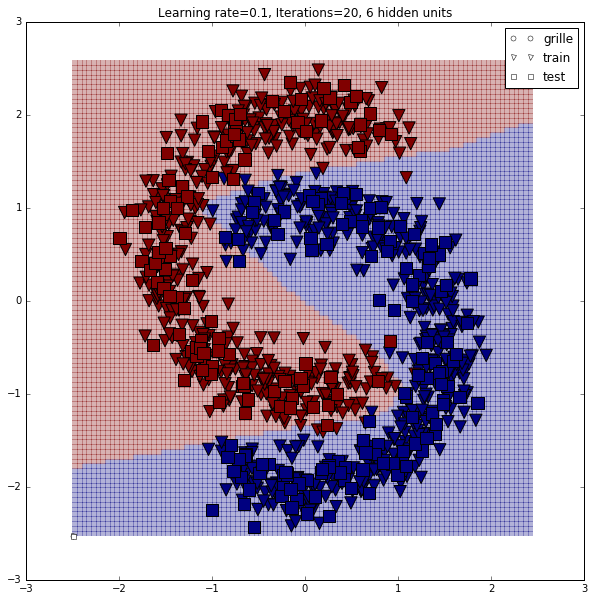

In [126]:
n_train = np.int(data.shape[0]*0.8)
inds = range(data.shape[0])
np.random.shuffle(inds)
train_inds = inds[:n_train]
test_inds = inds[n_train:]

traindata = data[train_inds,:]  
testdata = data[test_inds,:]

mlp = mlp_mini_batch(0.1, 2, 5, 2, epsilon=0.0001, minibatch_size=10, num_iterations=30, \
                     l11=0, l12=0, l21=0, l22=0)

mlp.train(traindata)

train_predictions = mlp.compute_predictions(traindata[:, :-1])
train_labels = traindata[:,-1]
train_err = 1.0 - np.mean(train_labels==train_predictions)
print "training error:",train_err*100

test_predictions = mlp.compute_predictions(testdata[:, :-1])
test_labels = testdata[:,-1]
test_err = 1.0 - np.mean(test_labels==test_predictions)
print "test error:",test_err*100

gridplot(classifieur=mlp, test=testdata, train=traindata, n_points=100, \
         title='Learning rate=0.1, Iterations=20, 6 hidden units')


#### We can see that a minimum number of epochs are needed to gain enough capacity to get good results. Also we don't need to run a lot of iterations. We can stop the training, in our case, after 30 iterations.

### Explore the effect of "elastic net" regularization

training error: 51.9318181818
test error: 47.7272727273


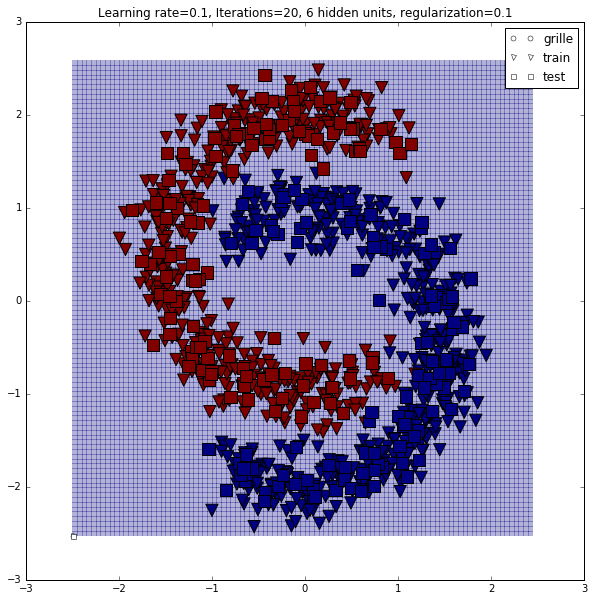

In [198]:
n_train = np.int(data.shape[0]*0.8)
inds = range(data.shape[0])
np.random.shuffle(inds)
train_inds = inds[:n_train]
test_inds = inds[n_train:]

traindata = data[train_inds,:]  
testdata = data[test_inds,:]

mlp = mlp_mini_batch(0.1, 2, 30, 2, epsilon=0.0001, minibatch_size=10, num_iterations=20, \
                     l11=0.1, l12=0.1, l21=0.1, l22=0.1)

mlp.train(traindata)

train_predictions = mlp.compute_predictions(traindata[:, :-1])
train_labels = traindata[:,-1]
train_err = 1.0 - np.mean(train_labels==train_predictions)
print "training error:",train_err*100

test_predictions = mlp.compute_predictions(testdata[:, :-1])
test_labels = testdata[:,-1]
test_err = 1.0 - np.mean(test_labels==test_predictions)
print "test error:",test_err*100

gridplot(classifieur=mlp, test=testdata, train=traindata, n_points=100, \
         title='Learning rate=0.1, Iterations=20, 6 hidden units, regularization=0.1')


training error: 22.1590909091
test error: 18.6363636364


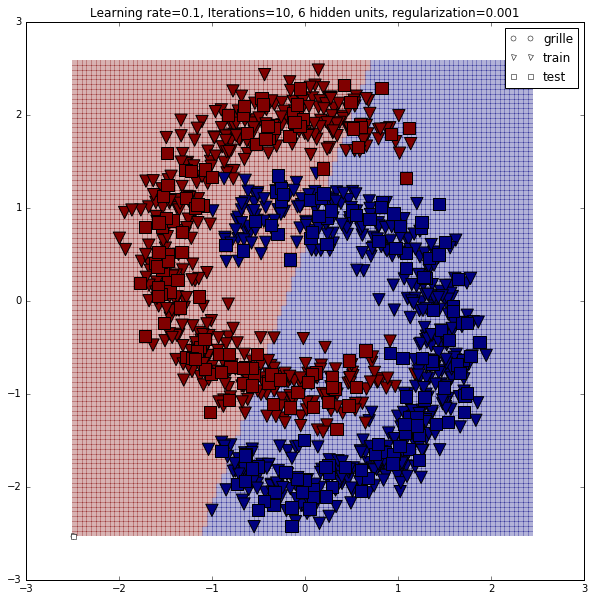

In [171]:
n_train = np.int(data.shape[0]*0.8)
inds = range(data.shape[0])
np.random.shuffle(inds)
train_inds = inds[:n_train]
test_inds = inds[n_train:]

traindata = data[train_inds,:]  
testdata = data[test_inds,:]

mlp = mlp_mini_batch(0.1, 2, 30, 2, epsilon=0.0001, minibatch_size=10, num_iterations=100, \
            l11=0.01, l12=0.01, l21=0.01, l22=0.01)

mlp.train(traindata)

train_predictions = mlp.compute_predictions(traindata[:, :-1])
train_labels = traindata[:,-1]
train_err = 1.0 - np.mean(train_labels==train_predictions)
print "training error:",train_err*100

test_predictions = mlp.compute_predictions(testdata[:, :-1])
test_labels = testdata[:,-1]
test_err = 1.0 - np.mean(test_labels==test_predictions)
print "test error:",test_err*100

gridplot(classifieur=mlp, test=testdata, train=traindata, n_points=100, \
         title='Learning rate=0.1, Iterations=100, 30 hidden units, regularization=0.01')


training error: 1.02272727273
test error: 0.909090909091


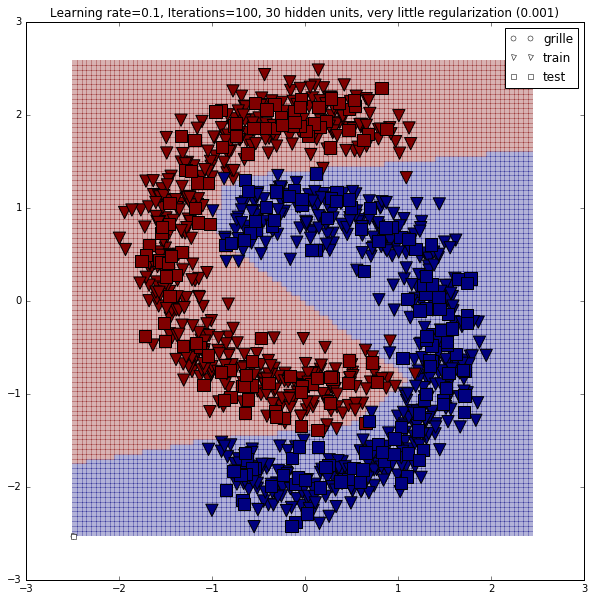

In [173]:
n_train = np.int(data.shape[0]*0.8)
inds = range(data.shape[0])
np.random.shuffle(inds)
train_inds = inds[:n_train]
test_inds = inds[n_train:]

traindata = data[train_inds,:]  
testdata = data[test_inds,:]

mlp = mlp_mini_batch(0.1, 2, 30, 2, epsilon=0.0001, minibatch_size=10, num_iterations=100, \
                     l11=0.001, l12=0.001, l21=0.001, l22=0.001)

mlp.train(traindata)

train_predictions = mlp.compute_predictions(traindata[:, :-1])
train_labels = traindata[:,-1]
train_err = 1.0 - np.mean(train_labels==train_predictions)
print "training error:",train_err*100

test_predictions = mlp.compute_predictions(testdata[:, :-1])
test_labels = testdata[:,-1]
test_err = 1.0 - np.mean(test_labels==test_predictions)
print "test error:",test_err*100

gridplot(classifieur=mlp, test=testdata, train=traindata, n_points=100, \
         title='Learning rate=0.1, Iterations=100, 30 hidden units, very little regularization (0.001)')


#### We can see that too high regularization is not good. If we are going to use regularization, we should use small values


### Question 6: Matrix implementation

In [208]:
class mlp_mini_batch_matrix:
    
    def __init__(self, eta, d, dh, m, epsilon, minibatch_size, num_iterations, 
                 l11, l12, l21, l22, hardcode_weights=False, shuffle_btw_epochs=False, target_valid_err_rate=4.0):
        self.l11 = l11
        self.l12 = l12
        self.l21 = l21
        self.l22 = l22
        self.target_valid_err_rate = target_valid_err_rate
        self.num_iterations = num_iterations
        self.epsilon = epsilon
        self.K = minibatch_size
        self.shuffle=shuffle_btw_epochs
        self.eta = eta
        self.d = d
        self.dh = dh
        self.m = m
        self.w1 = np.random.uniform(-1.0/np.sqrt(self.d), 1.0/np.sqrt(self.d), (self.dh, self.d))
        self.w2 = np.random.uniform(-1.0/np.sqrt(self.dh), 1.0/np.sqrt(self.dh), (self.m, self.dh))        
        self.b1 = np.zeros((dh, 1))
        self.b2 = np.zeros((m, 1))
        
        #Only used to compare gradients
        if (hardcode_weights == True):        
            self.w1[0][0] = -0.5
            self.w1[0][1] = 0.5
            self.w1[1][0] = -0.3
            self.w1[1][1] = 0.3

            self.w2[0][0] = -0.4
            self.w2[0][1] = 0.4
            self.w2[1][0] = -0.6
            self.w2[1][1] = 0.2
        
    def train(self, traindata, validdata=None, testdata=None, log_file=None):
        
        iteration = 0   
        valid_err = 100.0
        
        #To obtain the bonus, stop if the validation error is less than 2%
        while (iteration < self.num_iterations) and (valid_err*100 > self.target_valid_err_rate):
            
            self.loss = 0
            start_batch_i = 0
            train_err_batch = 0
            end_batch_i = np.minimum(self.K, traindata.shape[0])
        
            while start_batch_i < traindata.shape[0]: 
               
                samples = traindata[start_batch_i:end_batch_i, :-1]
                labels = traindata[start_batch_i:end_batch_i, -1]                                         

                self.fprop(samples)
                self.bprop(samples, labels)                                                   
                
                self.grad_w2 = self.grad_w2/samples.shape[0]
                self.grad_b2 = self.grad_b2/samples.shape[0]
                self.grad_w1 = self.grad_w1/samples.shape[0]
                self.grad_b1 = self.grad_b1/samples.shape[0]
                
                #Add the regularization factors
                self.grad_w2 = np.add(self.grad_w2, 2*self.l22*self.w2)
                self.grad_w2 = np.add(self.grad_w2, self.l21*np.sign(self.w2))                
                self.grad_w1 = np.add(self.grad_w1, 2*self.l12*self.w1)
                self.grad_w1 = np.add(self.grad_w1, self.l11*np.sign(self.w1))                

                self.apply_gradient_descent()            

                #After applying the gradient descent, run fprop again to compute the cost and the predictions
                #for this batch
                temp_os = self.fprop(samples)
                self.loss += self.cost(labels)   #cost() uses the updated self.os (updated via call to fprop)
                
                predictions_for_batch = np.argmax(temp_os, axis=0)                
                train_err_batch += (1.0 - np.mean(labels==predictions_for_batch))
                
                #Prepare the parameters for the next batch
                start_batch_i = end_batch_i
                end_batch_i = np.minimum(end_batch_i + self.K, traindata.shape[0])

            ######### Epoch finished ###########                                                                                      
            if (validdata is not None and testdata is not None):
                validdata_predictions = self.compute_predictions(validdata[:, :-1])   
                valid_labels = validdata[:,-1]
                valid_err = 1.0 - np.mean(valid_labels==validdata_predictions)

                testdata_predictions = self.compute_predictions(testdata[:, :-1])   
                test_labels = testdata[:,-1]
                test_err = 1.0 - np.mean(test_labels==testdata_predictions)                
                   
                #Tr/V/Te error / cost after iter {}: {}/{}/{} {}/{}/{}
                to_print= "{0:3d} {1:.2f} {2:.2f} {3:.2f} {4:.4f} {5:.4f} {6:.4f}".format(iteration, 
                        100*train_err_batch/(traindata.shape[0]/self.K), valid_err*100, test_err*100,                                                                                                        
                        self.loss/traindata.shape[0], self.avg_cost(validdata), self.avg_cost(testdata))
                print to_print
                
                if (log_file is not None):
                    log_file.write(to_print + '\n')
            
            iteration+=1   
            
            if (self.shuffle == True):
                inds = range(traindata.shape[0])
                np.random.shuffle(inds)
                traindata = traindata[inds,:] 
            

    def fprop(self, x):              
        self.ha = self.w1.dot(x.T) + self.b1
        #self.ha = np.add(self.w1.dot(x.T), self.b1*np.ones((self.dh, x.shape[0])))
        self.hs = np.where(self.ha > 0, self.ha, 0)
        #self.oa = np.add(self.w2.dot(self.hs), self.b2*np.ones((self.m, x.shape[0])))
        self.oa = self.w2.dot(self.hs) + self.b2
        self.os = softmax_m(self.oa)
        
        return self.os
        
    #x is a matrix of shape (K x d)
    #y is a column vector of (K x 1)
    def bprop(self, x, y):
        self.grad_oa = self.os - np.eye(self.m)[y.astype(int)].T
        #Sum over gradient for each sample
        self.grad_b2 = np.array([np.sum(self.grad_oa, axis=1)]).T
        
        self.grad_w2 = self.grad_oa.dot(self.hs.T)
        
        self.grad_hs = self.w2.T.dot(self.grad_oa)
        self.grad_ha = np.where(self.ha > 0, self.grad_hs, 0)
        self.grad_w1 = self.grad_ha.dot(x)
        
        #Sum over gradient for each sample
        self.grad_b1 = np.array([np.sum(self.grad_ha, axis=1)]).T
            
    def apply_gradient_descent(self):    
        self.w1-= self.eta*self.grad_w1
        self.w2-= self.eta*self.grad_w2
        self.b1-= self.eta*self.grad_b1
        self.b2-= self.eta*self.grad_b2
                
    def cost(self, y):
        #Cast y, which is a list of target outputs, as an integer array
        return np.sum(-np.log(self.os.T[np.arange(self.os.T.shape[0]), y.astype(int)]))     
    
    #Compute the average cost on the entire given dataset
    def avg_cost(self, dataset):
        dataset_x = dataset[:, :-1]
        dataset_y = dataset[:,-1]        
        fprop_data = self.fprop(dataset_x)
        
        return np.sum(-np.log(fprop_data.T[np.arange(fprop_data.T.shape[0]), dataset_y.astype(int)]))/dataset.shape[0]
    
    def print_vars(self):
        pprint(vars(self))
        
    #Parameter test_data does not contain labels
    #Return list of predictions
    def compute_predictions(self, test_data):
        #argmax over axis=0 because fprop will return matrix of shape (# of classes, # of data points)
        return np.argmax(self.fprop(test_data), axis=0)


### Question 7: Test gradients are the same for both implementations

Note that we fix the initial weights in both implementations to compare the gradients at the end of 10 epochs

In [33]:
traindata = np.loadtxt(open('2moons.txt','r'))
#Test gradients for both implementations
#Hardcode the initial values for weights w1 and w2
print "K=1------------------------------------------"
mlp = mlp_mini_batch_matrix(0.1, 2, 2, 2, epsilon=0.0001, minibatch_size=1, 
                              num_iterations=10, l11=0.001, l12=0.001, l21=0.001, l22=0.001, hardcode_weights=True)
mlp.train(traindata)
print "Matrix Calculus------------------------------"
print "Gradient w1", mlp.grad_w1
print "Gradient w2", mlp.grad_w2
print "Gradient b1", mlp.grad_b1
print "Gradient b2", mlp.grad_b2

mlp_loop = mlp_mini_batch(0.1, 2, 2, 2, epsilon=0.0001, minibatch_size=1, 
                              num_iterations=10, l11=0.001, l12=0.001, l21=0.001, l22=0.001, hardcode_weights=True)
mlp_loop.train(traindata)
print "Loop implementation---------------------------"
print "Gradient w1", mlp_loop.mb_grad_w1
print "Gradient w2", mlp_loop.mb_grad_w2
print "Gradient b1", mlp_loop.mb_grad_b1
print "Gradient b2", mlp_loop.mb_grad_b2

print "K=10------------------------------------------"
mlp = mlp_mini_batch_matrix(0.1, 2, 2, 2, epsilon=0.0001, minibatch_size=10, 
                              num_iterations=10, l11=0.001, l12=0.001, l21=0.001, l22=0.001, hardcode_weights=True)
mlp.train(traindata)
print "Matrix Calculus------------------------------"
print "Gradient w1", mlp.grad_w1
print "Gradient w2", mlp.grad_w2
print "Gradient b1", mlp.grad_b1
print "Gradient b2", mlp.grad_b2

mlp_loop = mlp_mini_batch(0.1, 2, 2, 2, epsilon=0.0001, minibatch_size=10, 
                              num_iterations=10, l11=0.001, l12=0.001, l21=0.001, l22=0.001, hardcode_weights=True)
mlp_loop.train(traindata)
print "Loop implementation---------------------------"
print "Gradient w1", mlp_loop.mb_grad_w1
print "Gradient w2", mlp_loop.mb_grad_w2
print "Gradient b1", mlp_loop.mb_grad_b1
print "Gradient b2", mlp_loop.mb_grad_b2

K=1------------------------------------------
Matrix Calculus------------------------------
Gradient w1 [[ 0.22877269  0.30083961]
 [ 0.02027711  0.02874133]]
Gradient w2 [[-0.15582931 -0.02311409]
 [ 0.15561339  0.02323198]]
Gradient b1 [[ 0.28082837]
 [ 0.02599873]]
Gradient b2 [[-0.2140955]
 [ 0.2140955]]
Loop implementation---------------------------
Gradient w1 [[ 0.22877269  0.30083961]
 [ 0.02027711  0.02874133]]
Gradient w2 [[-0.15582931 -0.02311409]
 [ 0.15561339  0.02323198]]
Gradient b1 [[ 0.28082837]
 [ 0.02599873]]
Gradient b2 [[-0.2140955]
 [ 0.2140955]]
K=10------------------------------------------
Matrix Calculus------------------------------
Gradient w1 [[-0.11251368 -0.13214981]
 [-0.01666959 -0.04723675]]
Gradient w2 [[-0.09922857  0.00404749]
 [ 0.09764393 -0.00114413]]
Gradient b1 [[ 0.07140677]
 [ 0.02260744]]
Gradient b2 [[-0.04664062]
 [ 0.04664062]]
Loop implementation---------------------------
Gradient w1 [[-0.11251368 -0.13214981]
 [-0.01666959 -0.04723675]

### Question 8: Time using MNIST


In [34]:
import gzip,pickle
f=gzip.open('mnist.pkl.gz')
data=pickle.load(f)
# data[0][0]: matrice de train data
# data[0][1]: vecteur des train labels

# data[1][0]: matrice de valid data
# data[1][1]: vecteur des valid labels

# data[2][0]: matrice de test data
# data[2][0]: vecteur des test labels

In [35]:
traindata_mnist = np.concatenate((data[0][0], np.array([data[0][1]]).T), axis=1)
validdata_mnist = np.concatenate((data[1][0], np.array([data[1][1]]).T), axis=1)
testdata_mnist = np.concatenate((data[2][0], np.array([data[2][1]]).T), axis=1)

In [36]:
mlp_loop = mlp_mini_batch(0.1, 784, 24, 10, epsilon=0.0001, minibatch_size=100, 
                              num_iterations=1,l11=0.0001, l12=0.0001, l21=0.0001, l22=0.0001)
mlp_matrix = mlp_mini_batch_matrix(0.1, 784, 24, 10, epsilon=0.0001, minibatch_size=100, 
                              num_iterations=1,l11=0.0001, l12=0.0001, l21=0.0001, l22=0.0001)

print "Test peformance of loop and matrix calculus implementation: 24 hidden neurons and minibatch size=100"
t1_loop = time.clock()
mlp_loop.train(traindata_mnist)
t2_loop = time.clock()
print "Time to do one epoch on MNIST - loop version: {} seconds".format(t2_loop - t1_loop)

t1_matrix = time.clock()
mlp_matrix.train(traindata_mnist)
t2_matrix = time.clock()
print "Time to do one epoch on MNIST - matrix calculus version: {} seconds".format(t2_matrix - t1_matrix)

Test peformance of loop and matrix calculus implementation: 24 hidden neurons and minibatch size=100
Time to do one epoch on MNIST - loop version: 4.667524 seconds
Time to do one epoch on MNIST - matrix calculus version: 2.46491 seconds


In [212]:
f = open('logfile.500.300epochs.txt', 'w')
#By default, stop once the validation error rate is less than 4%
mlp = mlp_mini_batch_matrix(0.09, 784, 500, 10, epsilon=0.0001, minibatch_size=100, 
                              num_iterations=300,l11=0.00005, l12=0.00015, l21=0.00005, l22=0.00015,
                              target_valid_err_rate=1.8)
mlp.train(traindata_mnist, validdata_mnist, testdata_mnist, log_file=f)

f.close()

  0 11.80 8.50 9.21 0.5274 0.3091 0.3217
  1 6.88 6.83 7.42 0.2576 0.2504 0.2594
  2 5.58 5.76 6.19 0.2116 0.2150 0.2220
  3 4.61 5.01 5.49 0.1813 0.1905 0.1959
  4 4.02 4.34 4.94 0.1594 0.1726 0.1767
  5 3.55 4.18 4.59 0.1427 0.1589 0.1621
  6 3.12 3.87 4.10 0.1298 0.1481 0.1505
  7 2.79 3.67 3.87 0.1193 0.1394 0.1411
  8 2.53 3.43 3.62 0.1108 0.1323 0.1335
  9 2.32 3.21 3.46 0.1038 0.1264 0.1271
 10 2.12 3.15 3.27 0.0978 0.1213 0.1217
 11 1.97 3.05 3.18 0.0927 0.1170 0.1172
 12 1.81 2.93 3.10 0.0882 0.1133 0.1133
 13 1.68 2.84 2.99 0.0843 0.1101 0.1099
 14 1.59 2.69 2.90 0.0808 0.1072 0.1069
 15 1.49 2.62 2.79 0.0777 0.1046 0.1042
 16 1.42 2.52 2.76 0.0750 0.1024 0.1018
 17 1.35 2.46 2.65 0.0725 0.1003 0.0998
 18 1.27 2.45 2.58 0.0702 0.0986 0.0978
 19 1.22 2.42 2.57 0.0682 0.0969 0.0961
 20 1.16 2.38 2.56 0.0663 0.0953 0.0944
 21 1.11 2.39 2.52 0.0646 0.0940 0.0930
 22 1.07 2.39 2.49 0.0630 0.0928 0.0917
 23 1.05 2.39 2.45 0.0616 0.0917 0.0905
 24 1.02 2.36 2.40 0.0603 0.0906 0.0894

205 0.33 1.92 1.86 0.0318 0.0717 0.0677
206 0.33 1.90 1.84 0.0318 0.0717 0.0676
207 0.33 1.91 1.85 0.0318 0.0718 0.0677
208 0.33 1.93 1.87 0.0317 0.0717 0.0676
209 0.33 1.90 1.86 0.0317 0.0716 0.0677
210 0.33 1.91 1.88 0.0317 0.0717 0.0675
211 0.33 1.91 1.85 0.0317 0.0717 0.0676
212 0.33 1.91 1.84 0.0317 0.0717 0.0675
213 0.33 1.92 1.85 0.0317 0.0717 0.0676
214 0.32 1.91 1.84 0.0316 0.0716 0.0676
215 0.33 1.91 1.85 0.0316 0.0717 0.0675
216 0.33 1.92 1.82 0.0316 0.0717 0.0675
217 0.33 1.93 1.85 0.0316 0.0717 0.0675
218 0.33 1.95 1.83 0.0316 0.0717 0.0674
219 0.32 1.95 1.83 0.0316 0.0717 0.0675
220 0.33 1.93 1.81 0.0315 0.0717 0.0674
221 0.32 1.92 1.83 0.0315 0.0717 0.0674
222 0.32 1.92 1.81 0.0315 0.0717 0.0674
223 0.32 1.93 1.83 0.0315 0.0716 0.0674
224 0.32 1.92 1.80 0.0315 0.0717 0.0674
225 0.33 1.94 1.81 0.0315 0.0716 0.0674
226 0.33 1.94 1.79 0.0315 0.0716 0.0673
227 0.31 1.94 1.83 0.0315 0.0716 0.0673
228 0.32 1.94 1.82 0.0314 0.0717 0.0673
229 0.32 1.93 1.80 0.0314 0.0717 0.0673


In [214]:
train_predictions = mlp.compute_predictions(traindata_mnist[:, :-1])
train_labels = traindata_mnist[:,-1]
train_err = 1.0 - np.mean(train_labels==train_predictions)
print "training error:",train_err*100

valid_predictions = mlp.compute_predictions(validdata_mnist[:, :-1])
valid_labels = validdata_mnist[:,-1]
valid_err = 1.0 - np.mean(valid_labels==valid_predictions)
print "validation error:",valid_err*100

test_predictions = mlp.compute_predictions(testdata_mnist[:, :-1])
test_labels = testdata_mnist[:,-1]
test_err = 1.0 - np.mean(test_labels==test_predictions)
print "test error:",test_err*100

training error: 0.772
validation error: 1.9
test error: 1.83


### Questions 9 and 10

The following hyperparameters give a test error rate of 1.93:
<ul>
    <li>Learning rate = 0.09</li>
    <li>Number of hidden neurons = 500</li>
    <li>Epochs = 140</li>
    <li>Lambda 11 = Lambda 21 = 0.00005</li>
    <li>Lambda 12 = Lambda 22 = 0.00015</li>
    <li>Minibatch size = 100</li>
</ul>    
Note that we actually ran 300 epochs but saw that it made sense to stop at 140 as it was then that the validation error rate went under 1.90. The file logfile.500.300epochs.txt includes the number of iteration, train, valid, test error rates and average loss for the train, valid and test data sets.

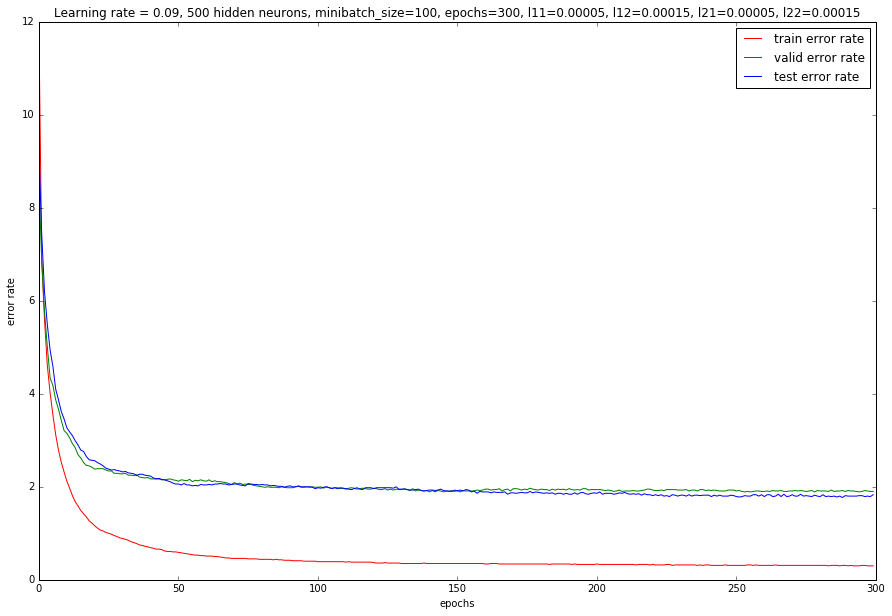

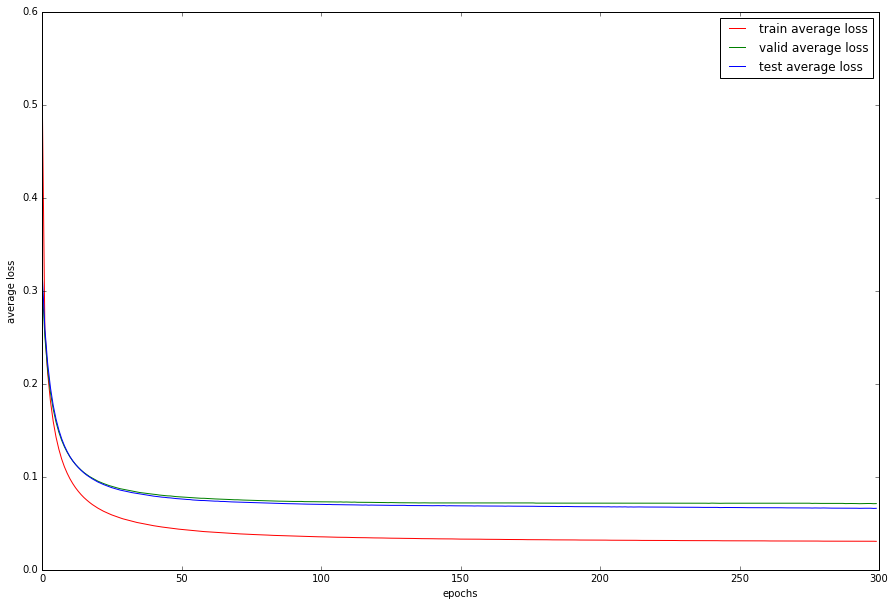

In [218]:
results= np.loadtxt(open('logfile.500.300epochs.txt','r'))

plt.figure(1, figsize(15,10))
iterations = results[:, 0].astype(int)
train_err_rate = results[:, 1]
valid_err_rate = results[:, 2]
test_err_rate = results[:, 3]
plt.plot(iterations, train_err_rate, c='r', label='train error rate')
plt.plot(iterations, valid_err_rate, c='g', label='valid error rate')
plt.plot(iterations, test_err_rate, c='b', label='test error rate')
plt.legend(loc='upper right')
plt.ylabel('error rate')
plt.xlabel('epochs')
plt.title('Learning rate = 0.09, 500 hidden neurons, minibatch_size=100, epochs=300, l11=0.00005, l12=0.00015, l21=0.00005, l22=0.00015')
plt.show()

plt.figure()
iterations = results[:, 0].astype(int)
train_err_rate = results[:, 4]
valid_err_rate = results[:, 5]
test_err_rate = results[:, 6]
plt.plot(iterations, train_err_rate, c='r', label='train average loss')
plt.plot(iterations, valid_err_rate, c='g', label='valid average loss')
plt.plot(iterations, test_err_rate, c='b', label='test average loss')
plt.legend(loc='upper right')
plt.ylabel('average loss')
plt.xlabel('epochs')
plt.show()